# Assignment 2 - Neural Networks Weights

Dongbo Zhang

dzhang48@gatech.edu

In [53]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import mlrose_hiive
import time
# Set constant variables
RANDOM_SEED = 7
N_FOLDS = 5
TEST_SIZE = 0.3
N_JOBS = -1
RANDOM_SEED_LIST = [7, 161117, 15, 123, 7641]

## Prepare Dataset

Credit Card Clients

Following the same steps used in Assignment 1 to prepare the data set.


In [54]:
# Load Data
cc_data = pd.read_excel('default of credit card clients.xls', header = [1])
cc_data = cc_data.rename(columns={'default payment next month': 'default_flag'})
# Drop NAs from the dataset
cc_data.dropna(inplace=True)


cc_data['SEX'] = cc_data['SEX'].replace(0, np.nan)
cc_data['SEX'] = cc_data['SEX'] - 1

marital_map = {1: 'MARRIED', 2:'SINGLE', 3:'OTHERS'}
cc_data = cc_data.replace({'MARRIAGE': marital_map})

cc_data['EDUCATION'] = cc_data['EDUCATION'].replace(0, np.nan)
cc_data['MARRIAGE'] = cc_data['MARRIAGE'].replace(0, 'NA')

# Assign fields to X (features) and y (dependent variable).
X = cc_data.iloc[:, 1:-1]
y = cc_data['default_flag'].values

### Plot the distribution of response variable

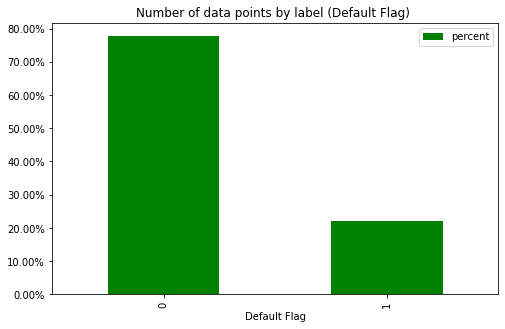

In [55]:

cnt_by_flag = cc_data.groupby('default_flag').size().reset_index()
cnt_by_flag['all_class'] = cc_data['default_flag'].count()
cnt_by_flag['percent'] = cnt_by_flag[0]/cnt_by_flag['all_class']
format_dict = {'percent': '{:.2%}'}
print(cnt_by_flag.style.format(format_dict))

# Plot the number of data points by label value
fig, ax = plt.subplots(figsize =(8,5))
cnt_by_flag.plot(x='default_flag', y='percent', kind='bar', ax=ax, color='green')
yticks = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in yticks])
plt.title("Number of data points by label (Default Flag) ")
plt.xlabel("Default Flag")
plt.savefig("problem1_overall.png", dpi=200)
plt.show()

### Split data to Train and Test sets

Divide the dataset to a training set (70%) and a test set (30%).

In [56]:
# Split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, 
                                                                    random_state=RANDOM_SEED, 
                                                                    test_size=TEST_SIZE)
label_name = 'default_flag'



### Preprocessing

The code of using ColumnTransformer is based on the example from SKLEARN
(https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)

In [57]:
# One-hot Encoding
X_train_all = pd.get_dummies(X_train_all, columns=['MARRIAGE'])
X_test_all = pd.get_dummies(X_test_all, columns=['MARRIAGE'])

continuous_features = ['LIMIT_BAL', 'EDUCATION', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
continuous_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy='median')),
                                           ('scaler', StandardScaler())])
preprocessing = ColumnTransformer(transformers=[('continuous', continuous_transformer, continuous_features)])


feature_names = X_train_all.columns

# Standard Scaling
X_train_all[continuous_features] = preprocessing.fit_transform(X_train_all)  
X_test_all[continuous_features] = preprocessing.transform(X_test_all) 

# Split the training set to train and validation set to tune parameters
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, random_state=RANDOM_SEED, test_size=TEST_SIZE)



## Neural Networks Weight Optimization

The best model in Assignment 1 uses parameters as below:

- Learning rate (alpha) = 0.0050
- Learning rate type = 'constant'
- Hidden layer = (15,)	
- Activation function = 'relu'

### Define a function to train and evaluate Neural Networks using different algorithms

In [58]:
def nn_train(mlpc, X_train, y_train, X_test, y_test):
    start_time = time.process_time()
    mlpc.fit(X_train, y_train)
    elapse = time.process_time() - start_time
    loss = mlpc.loss
    curve = mlpc.fitness_curve
    y_pred_train_label = mlpc.predict(X_train)
    y_pred_train_prob = mlpc.predicted_probs
    y_pred_test_label = mlpc.predict(X_test)
    y_pred_test_prob = mlpc.predicted_probs
    auc = {}
    auc['test'] = roc_auc_score(y_train, y_pred_train_prob)
    auc['train']= roc_auc_score(y_test, y_pred_test_prob)
    fit_time = elapse
        
    return mlpc, loss, curve, auc, fit_time

### Use the Neural Network function from mlrose_hiive

Given that the implementations differ between mlrose_hiive and scikit-learn, we refit the model to find the best learning rate.

In [ ]:
# Gradient Descent
gd_params = {'learning_rate':[0.0005, 0.0001, 0.001, 0.01]}

iterations = 2 ** np.arange(13)
res_gd = {'iter':[], 'train_auc':[], 'validation_auc':[], 'fit_time':[],'loss':[],'curve':[], 'learning_rate':[]}    
    

for alpha in gd_params['learning_rate']:
    for iter_ in iterations:
        gd_mlpc = mlrose_hiive.NeuralNetwork(hidden_nodes = [15], 
                                      activation = 'relu',
                                         algorithm = 'gradient_descent', max_iters = int(iter_),
                                         bias = True, is_classifier = True, learning_rate = alpha,
                                         early_stopping = True,  max_attempts = 100, clip_max=5,
                                         curve=True, random_state = RANDOM_SEED)

        gd_mlpc, loss, curve, auc, fit_time = nn_train(gd_mlpc, X_train, y_train, X_val, y_val)
        #print ('alpha=', alpha ,'iter=', iter_, 'loss=', loss, 'auc=', auc['test'])
        res_gd['train_auc'].append(auc['train'])
        res_gd['validation_auc'].append(auc['test'])
        res_gd['fit_time'].append(fit_time)
        res_gd['loss'].append(loss)
        res_gd['curve'].append(curve)
        res_gd['iter'].append(iter_)
        res_gd['learning_rate'].append(alpha)
    
    
pd.DataFrame(res_gd).to_csv('output_nn/gradient_descent_hp_tuning.csv', index=False)

Compare model performance using different hyperparameters:

The NN model using a learning rate of 0.0001 performs the best based on loss and validation ROC-AUC, and requires slightly more fitting time compared to other settings.

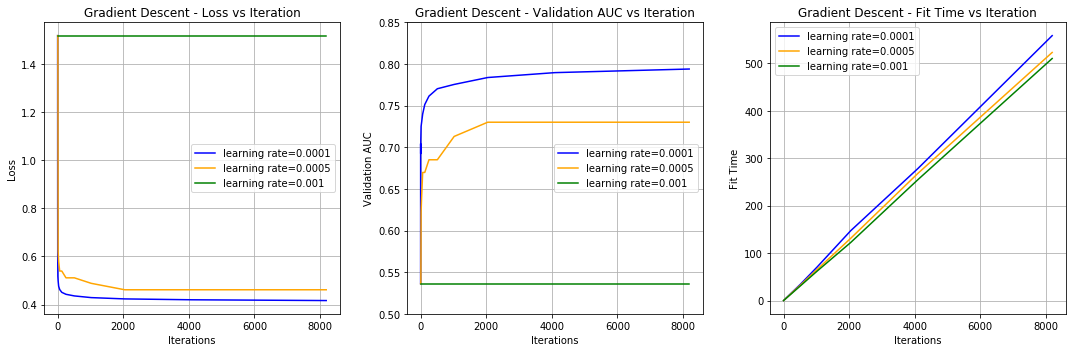

In [59]:
res_gd_df = pd.read_csv('output_nn/gradient_descent_hp_tuning.csv')
# Plot loss vs iterations
gd_params = {'learning_rate':[0.0001, 0.0005, 0.001]}
colors = ['b','orange','g']
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, lr in enumerate(gd_params['learning_rate']):
    ax[0].plot(res_gd_df[(res_gd_df.learning_rate==lr)]['iter'],
                 res_gd_df[(res_gd_df.learning_rate==lr)]['loss'], 
                 label="learning rate={}".format(lr), color=colors[i])
        
    ax[1].plot(res_gd_df[(res_gd_df.learning_rate==lr)]['iter'],
                 res_gd_df[(res_gd_df.learning_rate==lr)]['validation_auc'], 
                 label="learning rate={}".format(lr), color=colors[i])
    
    ax[2].plot(res_gd_df[(res_gd_df.learning_rate==lr)]['iter'],
                 res_gd_df[(res_gd_df.learning_rate==lr)]['fit_time'], 
                 label="learning rate={}".format(lr), color=colors[i])
        
ax[0].set_title("Gradient Descent - Loss vs Iteration")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].set_title("Gradient Descent - Validation AUC vs Iteration")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Validation AUC")
ax[1].set_ylim([0.5, 0.85])
ax[2].set_title("Gradient Descent - Fit Time vs Iteration")
ax[2].set_xlabel("Iterations")
ax[2].set_ylabel("Fit Time")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
plt.tight_layout()
plt.savefig("output_nn/gradient_descent_hp.png", dpi=200)
plt.show()

### Randomized Hill Climbing (RHC)

First, tune hyperparameters for the NN classifier using RHC algorithm.

In [ ]:
rhc_params = {'restarts':[3, 5, 10],
             'learning_rate':[0.01, 0.1, 0.5]}

iterations = 2 ** np.arange(13)
# Hyper Parameter Tuning
# learning rate and restarts
for seed_idx in range(len(RANDOM_SEED_LIST)):
    #print (RANDOM_SEED_LIST[seed_idx])
    res_rhc = {'iter':[], 'train_auc':[], 'validation_auc':[], 'fit_time':[],'loss':[],'curve':[],
         'restarts':[], 'learning_rate':[]}


    for r in rhc_params['restarts']:
        for alpha in rhc_params['learning_rate']:
            for iter_ in iterations:
    
                rhc_mlpc = mlrose_hiive.NeuralNetwork(hidden_nodes = [15], 
                                    activation = 'relu',
                                    algorithm = 'random_hill_climb', max_iters = int(iter_),
                                    bias = True, is_classifier = True, learning_rate = alpha,
                                    early_stopping = True,  max_attempts = 100, clip_max=5,
                                    restarts=r, curve=True, random_state = RANDOM_SEED)
                rhc_mlpc, loss, curve, auc, fit_time = nn_train(rhc_mlpc, X_train, y_train, X_val, y_val)
                #print ('restarts=', r,'alpha=', alpha ,'iter=', iter_, 'loss=', loss, 'auc=', auc['test'])
                res_rhc['train_auc'].append(auc['train'])
                res_rhc['validation_auc'].append(auc['test'])
                res_rhc['fit_time'].append(fit_time)
                res_rhc['loss'].append(loss)
                res_rhc['curve'].append(curve)
                res_rhc['iter'].append(iter_)
                res_rhc['restarts'].append(r)
                res_rhc['learning_rate'].append(alpha)
            
    pd.DataFrame(res_rhc).to_csv('output_nn/rhc_hp_tuning_new_{}.csv'.format(seed_idx), index=False)

### Plot model performance using RHC and different parameters

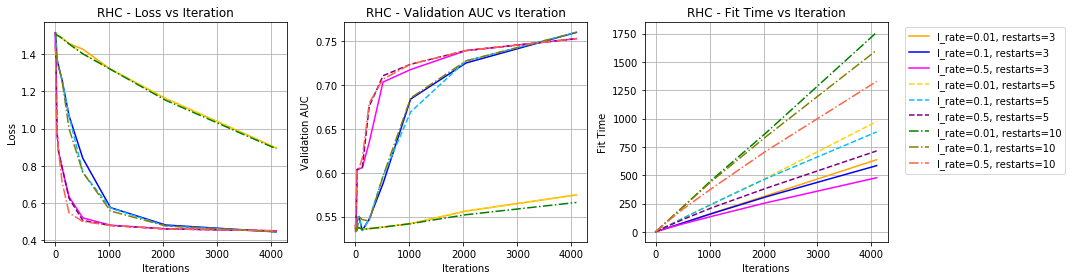

In [60]:
# Load RHC result data
res_rhc_df_orig = pd.DataFrame()
for i in range(5):
    tmp_df = pd.read_csv('output_nn/rhc_hp_tuning_new_{}.csv'.format(i))
    res_rhc_df_orig = pd.concat([res_rhc_df_orig,tmp_df], axis=0)
    
    
res_rhc_df = res_rhc_df_orig.groupby(['iter', 'restarts','learning_rate'])[['train_auc','validation_auc','fit_time','loss']].mean().reset_index()
# RHC hyperparameters
rhc_params = {'restarts':[3, 5, 10],
             'learning_rate':[0.01, 0.1, 0.5]}
colors = [['orange','b','magenta'], ['gold','deepskyblue','purple'], ['g','olive','tomato']]
line_styles=['-','--','-.']

# Plot loss vs iterations
fig, ax = plt.subplots(1,3, figsize=(15,4))
for j, r in enumerate(rhc_params['restarts']):
    learn_rates = rhc_params['learning_rate']
    for i, lr in enumerate(learn_rates):
        ax[0].plot(res_rhc_df[(res_rhc_df.learning_rate==lr)&(res_rhc_df.restarts==r)]['iter'],
                 res_rhc_df[(res_rhc_df.learning_rate==lr)&(res_rhc_df.restarts==r)]['loss'], 
                 label="l_rate={}, restarts={}".format(lr, r), color=colors[j][i], linestyle=line_styles[j])
        
        ax[1].plot(res_rhc_df[(res_rhc_df.learning_rate==lr)&(res_rhc_df.restarts==r)]['iter'],
                 res_rhc_df[(res_rhc_df.learning_rate==lr)&(res_rhc_df.restarts==r)]['validation_auc'], 
                 label="l_rate={}, restarts={}".format(lr, r), color=colors[j][i],linestyle=line_styles[j])
    
        ax[2].plot(res_rhc_df[(res_rhc_df.learning_rate==lr)&(res_rhc_df.restarts==r)]['iter'],
                 res_rhc_df[(res_rhc_df.learning_rate==lr)&(res_rhc_df.restarts==r)]['fit_time'], 
                 label="l_rate={}, restarts={}".format(lr, r), color=colors[j][i],linestyle=line_styles[j])
        
ax[0].set_title("RHC - Loss vs Iteration")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].set_title("RHC - Validation AUC vs Iteration")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Validation AUC")
ax[2].set_title("RHC - Fit Time vs Iteration")
ax[2].set_xlabel("Iterations")
ax[2].set_ylabel("Fit Time")
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
handles, labels = ax[0].get_legend_handles_labels()
#fig.legend(labels, loc='lower center', bbox_to_anchor=(0.5, -0.04), ncol=5, frameon=False)
#fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
#          fancybox=True, shadow=True, ncol=6)
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("output_nn/rhc_hp.png", dpi=200)
plt.show()

The plots show that the NN models using RHC with same learning rate converge at similar speed and perform similarly. The models using larger number of restarts performs more slowly. Among the three learning rates tested, the alpha of 0.5 performs the best. Therefore, the best hyperparameters are learning rate = 0.5 and restarts = 3.


### Simulated Annealing (SA)

First, tune hyperparameters for the NN classifier using SA algorithm.

In [ ]:
sa_params = {'schedule':[mlrose_hiive.GeomDecay(), mlrose_hiive.ExpDecay()],
             'learning_rate':[0.01, 0.1, 0.5, 1.0]}
schedule_name = ['GeoDecay', 'ExpDecay']
iterations = 2 ** np.arange(13)

for seed_idx in range(len(RANDOM_SEED_LIST)):
    print (RANDOM_SEED_LIST[seed_idx])
    res_sa = {'iter':[], 'train_auc':[], 'validation_auc':[], 'fit_time':[],'loss':[],'curve':[],
         'schedule':[], 'learning_rate':[]}
    for i in range(len(sa_params['schedule'])):
        for alpha in sa_params['learning_rate']:
            for iter_ in iterations:
                sa_mlpc = mlrose_hiive.NeuralNetwork(hidden_nodes = [15], 
                                    activation = 'relu',
                                         algorithm = 'simulated_annealing', max_iters = int(iter_),
                                         bias = True, is_classifier = True, learning_rate = alpha,
                                         early_stopping = True,  max_attempts = 100, clip_max=5,
                                         curve=True, random_state = RANDOM_SEED_LIST[seed_idx],
                                        schedule = sa_params['schedule'][i])

                sa_mlpc, loss, curve, auc, fit_time = nn_train(sa_mlpc, X_train, y_train, X_val, y_val)
                print ('schedule=', schedule_name[i],'alpha=', alpha ,'iter=', iter_, 'loss=', loss, 'auc=', auc['test'])
                res_sa['train_auc'].append(auc['train'])
                res_sa['validation_auc'].append(auc['test'])
                res_sa['fit_time'].append(fit_time)
                res_sa['loss'].append(loss)
                res_sa['curve'].append(curve)
                res_sa['iter'].append(iter_)
                res_sa['schedule'].append(schedule_name[i])
                res_sa['learning_rate'].append(alpha)
            
    pd.DataFrame(res_sa).to_csv('output_nn/sa_hp_tuning_{}.csv'.format(seed_idx), index=False)

### Plot model performance using SA and different parameters

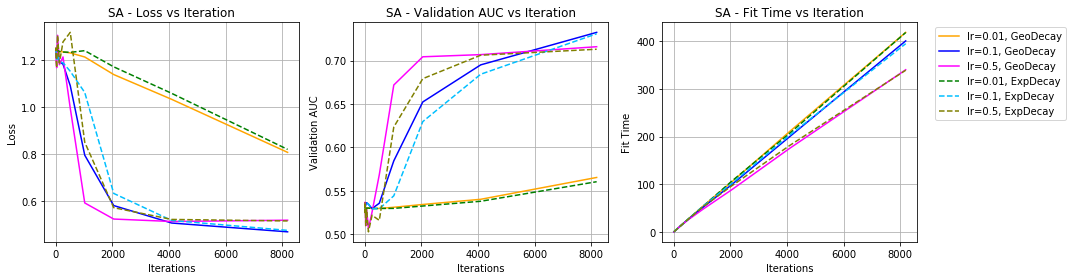

In [62]:
# Load SA result data
res_sa_df_orig = pd.DataFrame()
for i in range(len(RANDOM_SEED_LIST)):
    tmp_df = pd.read_csv('output_nn/sa_hp_tuning_{}.csv'.format(i))
    res_sa_df_orig = pd.concat([res_sa_df_orig,tmp_df], axis=0)
    
res_sa_df = res_sa_df_orig.groupby(['iter', 'schedule','learning_rate'])[['train_auc','validation_auc','fit_time','loss']].mean().reset_index()
#res_sa_df = res_sa_df[res_sa_df.iter<=2**12]

# SA hyperparameters
sa_params = {'schedule':[mlrose_hiive.GeomDecay(), mlrose_hiive.ExpDecay()],
             'learning_rate':[0.01, 0.1, 0.5], 
             'schedule_name': ['GeoDecay', 'ExpDecay']}
colors = [['orange','b','magenta'], ['g','deepskyblue','olive',]]
line_styles=['-','--']


# Plot loss vs iterations
fig, ax = plt.subplots(1,3, figsize=(15,4))
for j, schedule in enumerate(sa_params['schedule_name']):
    for i, lr in enumerate(sa_params['learning_rate']):
        ax[0].plot(res_sa_df[(res_sa_df.learning_rate==lr)&(res_sa_df.schedule==schedule)]['iter'],
                 res_sa_df[(res_sa_df.learning_rate==lr)&(res_sa_df.schedule==schedule)]['loss'], 
                 label="lr={}, {}".format(lr, schedule), color=colors[j][i], linestyle=line_styles[j])
        
        ax[1].plot(res_sa_df[(res_sa_df.learning_rate==lr)&(res_sa_df.schedule==schedule)]['iter'],
                 res_sa_df[(res_sa_df.learning_rate==lr)&(res_sa_df.schedule==schedule)]['validation_auc'], 
                 label="lr={}, {}".format(lr, schedule), color=colors[j][i], linestyle=line_styles[j])
    
        ax[2].plot(res_sa_df[(res_sa_df.learning_rate==lr)&(res_sa_df.schedule==schedule)]['iter'],
                 res_sa_df[(res_sa_df.learning_rate==lr)&(res_sa_df.schedule==schedule)]['fit_time'], 
                 label="lr={}, {}".format(lr, schedule), color=colors[j][i], linestyle=line_styles[j])
    
        
ax[0].set_title("SA - Loss vs Iteration")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].set_title("SA - Validation AUC vs Iteration")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Validation AUC")
ax[2].set_title("SA - Fit Time vs Iteration")
ax[2].set_xlabel("Iterations")
ax[2].set_ylabel("Fit Time")
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
handles, labels = ax[0].get_legend_handles_labels()

plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

#fig.legend(labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=6, frameon=False)
plt.tight_layout()
plt.savefig("output_nn/sa_hp.png", dpi=200)
plt.show()

The plots show that the NN models using SA converges faster to the optima with geometric decay schedule and a learning rate of 0.5



### Genetic Algorithm (GA)

In [ ]:
# Genetic Algorithm
ga_params = {'mutation_prob':[0.01, 0.1, 0.3],
             'pop_size': [100, 200],
             'learning_rate':[0.1, 0.5]}

iterations = 2 ** np.arange(13)

for seed_idx in range(2,len(RANDOM_SEED_LIST),2):
    print (RANDOM_SEED_LIST[seed_idx])
    res_ga = {'iter':[], 'train_auc':[], 'validation_auc':[], 'fit_time':[],'loss':[],'curve':[],
         'mutation_prob':[], 'learning_rate':[], 'pop_size':[]}
    for pop_size in ga_params['pop_size']:
        for mut_prob in ga_params['mutation_prob']:
            for alpha in ga_params['learning_rate']:
                for iter_ in iterations:
                    ga_mlpc = mlrose_hiive.NeuralNetwork(hidden_nodes = [15], 
                                    activation = 'relu',
                                         algorithm = 'genetic_alg', max_iters = int(iter_),
                                         bias = True, is_classifier = True, learning_rate = alpha,
                                         early_stopping = True,  max_attempts = 100, clip_max=5,
                                         curve=True, random_state = RANDOM_SEED,
                                         pop_size=pop_size, mutation_prob=mut_prob)

                    ga_mlpc, loss, curve, auc, fit_time = nn_train(ga_mlpc, X_train, y_train, X_val, y_val)
                    #print ('pop_size=', pop_size,'mut_prob=', mut_prob,'alpha=', alpha ,'iter=', iter_, 'loss=', loss, 'auc=', auc['test'])
                    res_ga['train_auc'].append(auc['train'])
                    res_ga['validation_auc'].append(auc['test'])
                    res_ga['fit_time'].append(fit_time)
                    res_ga['loss'].append(loss)
                    res_ga['curve'].append(curve)
                    res_ga['iter'].append(iter_)
                    res_ga['pop_size'].append(pop_size)
                    res_ga['mutation_prob'].append(mut_prob)
                    res_ga['learning_rate'].append(alpha)
    
    pd.DataFrame(res_ga).to_csv('output_nn/ga_hp_tuning_{}.csv'.format(seed_idx), index=False)

### Plot model performance using GA and different parameters

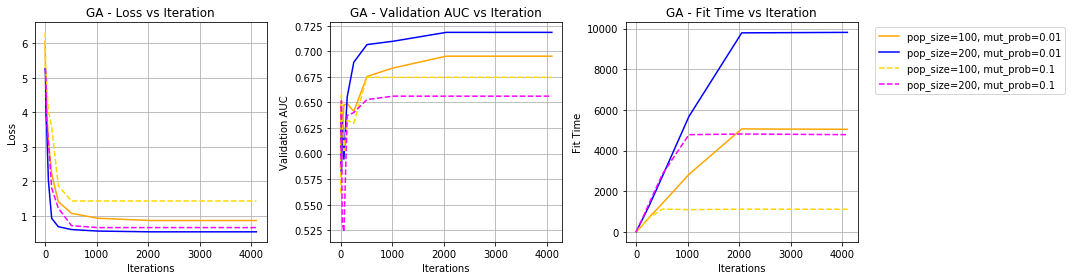

In [63]:
# Load GA result data
res_ga_df_orig = pd.DataFrame()
for i in range(len(RANDOM_SEED_LIST)):
    tmp_df = pd.read_csv('output_nn/ga_hp_tuning_{}.csv'.format(i))
    res_ga_df_orig = pd.concat([res_ga_df_orig,tmp_df], axis=0)
    
    
res_ga_df = res_ga_df_orig.groupby(['iter', 'pop_size','mutation_prob', 'learning_rate'])[['train_auc','validation_auc','fit_time','loss']].mean().reset_index()
# GA hyperparameters
ga_params = {'mutation_prob':[0.01, 0.1],
             'pop_size': [100, 200]}
lr = 0.1
colors = [['orange','b'],['gold', 'magenta' ],['deepskyblue','tomato'], ['g','olive']]
line_styles=['-','--','-.']

# Plot loss vs iterations
fig, ax = plt.subplots(1,3, figsize=(15,4))
for j, rate in enumerate(ga_params['mutation_prob']):
    for k, pop in enumerate(ga_params['pop_size']):
        ax[0].plot(res_ga_df[(res_ga_df.learning_rate==lr)&(res_ga_df.mutation_prob==rate)&
                            (res_ga_df.pop_size==pop)]['iter'],
                 res_ga_df[(res_ga_df.learning_rate==lr)&(res_ga_df.mutation_prob==rate)&
                          (res_ga_df.pop_size==pop)]['loss'], 
                 label="pop_size={}, mut_prob={}".format( pop, rate), color=colors[j][k], linestyle=line_styles[j])
        
        ax[1].plot(res_ga_df[(res_ga_df.learning_rate==lr)&(res_ga_df.mutation_prob==rate)&
                            (res_ga_df.pop_size==pop)]['iter'],
                 res_ga_df[(res_ga_df.learning_rate==lr)&(res_ga_df.mutation_prob==rate)&
                          (res_ga_df.pop_size==pop)]['validation_auc'], 
                 label="pop_size={}, mut_prob={}".format(lr, pop, rate), color=colors[j][k], linestyle=line_styles[j])
        
        ax[2].plot(res_ga_df[(res_ga_df.learning_rate==lr)&(res_ga_df.mutation_prob==rate)&
                            (res_ga_df.pop_size==pop)]['iter'],
                 res_ga_df[(res_ga_df.learning_rate==lr)&(res_ga_df.mutation_prob==rate)&
                          (res_ga_df.pop_size==pop)]['fit_time'], 
                 label="pop_size={}, mut_prob={}".format(lr, pop, rate), color=colors[j][k], linestyle=line_styles[j])
        
        
ax[0].set_title("GA - Loss vs Iteration")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].set_title("GA - Validation AUC vs Iteration")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Validation AUC")
ax[2].set_title("GA - Fit Time vs Iteration")
ax[2].set_xlabel("Iterations")
ax[2].set_ylabel("Fit Time")
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
handles, labels = ax[0].get_legend_handles_labels()
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("output_nn/GA_hp.png", dpi=200)
plt.show()

The results show that the NN model using GA with a larger population size (200) and a larger mutation probability (0.1) generates more accurte ouputs but requires longer fitting time.

### Comparison

Use the best hyper parameters for four NN classifiers 



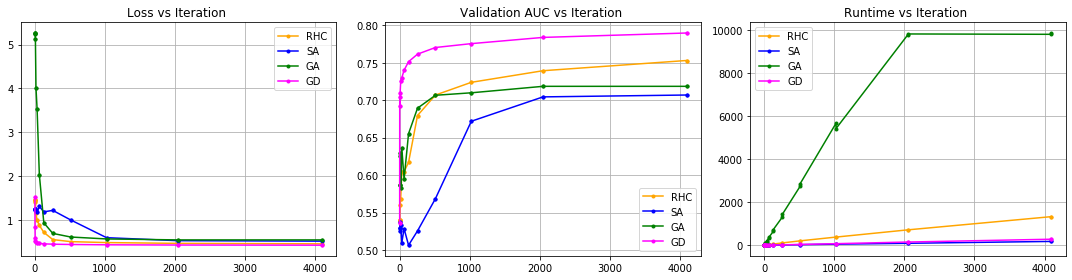

In [68]:
### COmparison
best_gd = res_gd_df[res_gd_df.learning_rate==0.0001].reset_index(drop=False)
best_rhc = res_rhc_df[(res_rhc_df['restarts']==10) &(res_rhc_df['learning_rate']==0.5)].reset_index(drop=False)
best_sa = res_sa_df[(res_sa_df['schedule']=='GeoDecay')&
                       (res_sa_df['learning_rate']==0.5)].reset_index(drop=False)
best_ga = res_ga_df[(res_ga_df['pop_size']==200)&
                       (res_ga_df['mutation_prob']==0.01)].reset_index(drop=False)


comparison = pd.merge(best_rhc, best_sa, on='iter', suffixes=('_rhc','_sa'))
comparison = pd.merge(comparison, best_ga, on='iter')
comparison = comparison.rename(columns={'fit_time':'fit_time_ga', 'validation_auc':'validation_auc_ga',
                                        'train_auc':'train_auc_ga',
                                       'loss':'loss_ga'})
comparison = pd.merge(comparison, best_gd, on='iter')
comparison = comparison.rename(columns={'fit_time':'fit_time_gd', 'validation_auc':'validation_auc_gd',
                                        'train_auc':'train_auc_gd',
                                       'loss':'loss_gd'})

fig, ax = plt.subplots(1,3, figsize=(15,4))

ax[0].plot(comparison['iter'], comparison['loss_rhc'], label="RHC", marker=".", color='orange')
ax[0].plot(comparison['iter'], comparison['loss_sa'], label="SA", marker=".", color='blue')
ax[0].plot(comparison['iter'], comparison['loss_ga'], label="GA", marker=".", color='green')
ax[0].plot(comparison['iter'], comparison['loss_gd'], label="GD", marker=".", color='magenta')
ax[1].plot(comparison['iter'], comparison['validation_auc_rhc'], label="RHC", marker=".", color='orange')
ax[1].plot(comparison['iter'], comparison['validation_auc_sa'], label="SA", marker=".", color='blue')
ax[1].plot(comparison['iter'], comparison['validation_auc_ga'], label="GA", marker=".", color='green')
ax[1].plot(comparison['iter'], comparison['validation_auc_gd'], label="GD", marker=".", color='magenta')
ax[2].plot(comparison['iter'], comparison['fit_time_rhc'], label="RHC", marker=".", color='orange')
ax[2].plot(comparison['iter'], comparison['fit_time_sa'], label="SA", marker=".", color='blue')
ax[2].plot(comparison['iter'], comparison['fit_time_ga'], label="GA", marker=".", color='green')
ax[2].plot(comparison['iter'], comparison['fit_time_gd'], label="GD", marker=".", color='magenta')

ax[0].set_title("Loss vs Iteration ")
ax[1].set_title("Validation AUC vs Iteration ")
ax[2].set_title("Runtime vs Iteration ")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
plt.tight_layout()
plt.savefig('comparison.png',dpi=200)
plt.show()

In [ ]:
iterations = 2 ** np.arange(11)
for seed_idx in range(len(RANDOM_SEED_LIST)):
    print (RANDOM_SEED_LIST[seed_idx])
    res = {'iter':[], 'sa_train_auc':[],'ga_train_auc':[],'gd_train_auc':[],'rhc_train_auc':[],
            'sa_test_auc':[],'ga_test_auc':[],'gd_test_auc':[],'rhc_test_auc':[],
            'sa_fit_time':[],'ga_fit_time':[],'gd_fit_time':[],'rhc_fit_time':[],
            'sa_loss':[],'ga_loss':[],'gd_loss':[],'rhc_loss':[]}
    for iter_ in iterations:
        res['iter'].append(iter_)
        gd_mlpc = mlrose_hiive.NeuralNetwork(hidden_nodes = [15], 
                                      activation = 'relu',
                                         algorithm = 'gradient_descent', max_iters = int(iter_),
                                         bias = True, is_classifier = True, learning_rate = 0.0001,
                                         early_stopping = True,  max_attempts = 100, clip_max=5,
                                         curve=True, random_state = RANDOM_SEED_LIST[seed_idx])

        gd_mlpc, loss, curve, auc, fit_time = nn_train(gd_mlpc, X_train_all, y_train_all, X_test_all, y_test_all)
        print ('GD', 'iter=', iter_, 'loss=', loss, 'auc=', auc['test'])
        res['gd_train_auc'].append(auc['train'])
        res['gd_test_auc'].append(auc['test'])
        res['gd_loss'].append(loss)
        res['gd_fit_time'].append(fit_time)
        
        sa_mlpc = mlrose_hiive.NeuralNetwork(hidden_nodes = [15], 
                                    activation = 'relu',
                                         algorithm = 'simulated_annealing', max_iters = int(iter_),
                                         bias = True, is_classifier = True, learning_rate = 0.5,
                                         early_stopping = True,  max_attempts = 100, clip_max=5,
                                         curve=True, random_state = RANDOM_SEED_LIST[seed_idx],
                                        schedule = mlrose_hiive.GeomDecay())

        sa_mlpc, loss, curve, auc, fit_time = nn_train(sa_mlpc, X_train_all, y_train_all, X_test_all, y_test_all)
        print ('SA', 'iter=', iter_, 'loss=', loss, 'auc=', auc['test'])
        res['sa_train_auc'].append(auc['train'])
        res['sa_test_auc'].append(auc['test'])
        res['sa_loss'].append(loss)
        res['sa_fit_time'].append(fit_time)
        
        rhc_mlpc = mlrose_hiive.NeuralNetwork(hidden_nodes = [15], 
                                    activation = 'relu',
                                    algorithm = 'random_hill_climb', max_iters = int(iter_),
                                    bias = True, is_classifier = True, learning_rate = 0.5,
                                    early_stopping = True,  max_attempts = 100, clip_max=5,
                                    restarts=10, curve=True, random_state = RANDOM_SEED_LIST[seed_idx])
        rhc_mlpc, loss, curve, auc, fit_time = nn_train(rhc_mlpc, X_train_all, y_train_all, X_test_all, y_test_all)
        print ('RHC', 'iter=', iter_, 'loss=', loss, 'auc=', auc['test'])
        res['rhc_train_auc'].append(auc['train'])
        res['rhc_test_auc'].append(auc['test'])
        res['rhc_loss'].append(loss)
        res['rhc_fit_time'].append(fit_time)
        
        ga_mlpc = mlrose_hiive.NeuralNetwork(hidden_nodes = [15], 
                                    activation = 'relu',
                                         algorithm = 'genetic_alg', max_iters = int(iter_),
                                         bias = True, is_classifier = True, learning_rate = 0.1,
                                         early_stopping = True,  max_attempts = 100, clip_max=5,
                                         curve=True, random_state = RANDOM_SEED_LIST[seed_idx],
                                         pop_size=200, mutation_prob=0.01)

        ga_mlpc, loss, curve, auc, fit_time = nn_train(ga_mlpc, X_train_all, y_train_all, X_test_all, y_test_all)
        print ('GA', 'iter=', iter_, 'loss=', loss, 'auc=', auc['test'])
        res['ga_train_auc'].append(auc['train'])
        res['ga_test_auc'].append(auc['test'])
        res['ga_loss'].append(loss)
        res['ga_fit_time'].append(fit_time)
        
    pd.DataFrame(res).to_csv('output_nn/compare_{}.csv'.format(seed_idx), index=False)



7
GD iter= 1 loss= 1.5425131183886067 auc= 0.5349099620527962
SA iter= 1 loss= 1.5324210843048052 auc= 0.538668276249335
RHC iter= 1 loss= 1.466495777016946 auc= 0.5388111606639726
GA iter= 1 loss= 5.345336170245752 auc= 0.587091182047677
GD iter= 2 loss= 0.9902808892093817 auc= 0.6921815025699546
SA iter= 2 loss= 1.5324210843048052 auc= 0.538668276249335
RHC iter= 2 loss= 1.466495777016946 auc= 0.5388111606639726
GA iter= 2 loss= 5.345336170245752 auc= 0.587091182047677
GD iter= 4 loss= 0.6039835068426624 auc= 0.6588043788622016
SA iter= 4 loss= 1.445022192349277 auc= 0.5461091876656637
RHC iter= 4 loss= 1.465645542397498 auc= 0.5376549554632113
GA iter= 4 loss= 5.345336170245752 auc= 0.587091182047677
GD iter= 8 loss= 0.4973614723064661 auc= 0.704831692043113
SA iter= 8 loss= 1.371187499726873 auc= 0.560649679523723
RHC iter= 8 loss= 1.421117865819049 auc= 0.5590620347573912
GA iter= 8 loss= 4.963271482917897 auc= 0.5777033940880695
GD iter= 16 loss= 0.4971314650067981 auc= 0.7204944

In [66]:
result = pd.DataFrame()
for i in range(1):
    tmp_df = pd.read_csv('output_nn/compare_{}.csv'.format(i))
    result = pd.concat([result,tmp_df], axis=0)

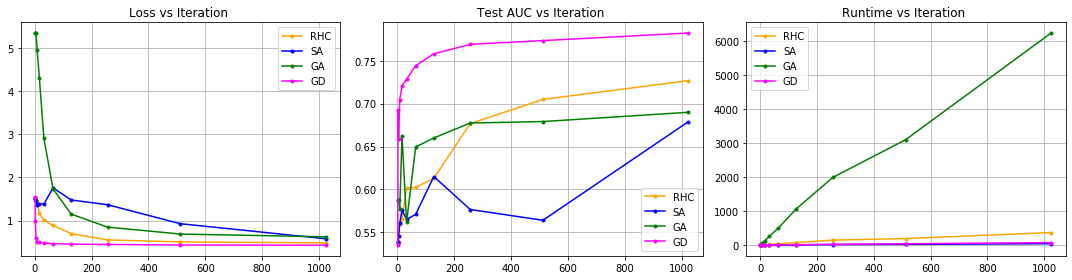

In [67]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

ax[0].plot(result['iter'], result['rhc_loss'], label="RHC", marker=".", color='orange')
ax[0].plot(result['iter'], result['sa_loss'], label="SA", marker=".", color='blue')
ax[0].plot(result['iter'], result['ga_loss'], label="GA", marker=".", color='green')
ax[0].plot(result['iter'], result['gd_loss'], label="GD", marker=".", color='magenta')
ax[1].plot(result['iter'], result['rhc_test_auc'], label="RHC", marker=".", color='orange')
ax[1].plot(result['iter'], result['sa_test_auc'], label="SA", marker=".", color='blue')
ax[1].plot(result['iter'], result['ga_test_auc'], label="GA", marker=".", color='green')
ax[1].plot(result['iter'], result['gd_test_auc'], label="GD", marker=".", color='magenta')
ax[2].plot(result['iter'], result['rhc_fit_time'], label="RHC", marker=".", color='orange')
ax[2].plot(result['iter'], result['sa_fit_time'], label="SA", marker=".", color='blue')
ax[2].plot(result['iter'], result['ga_fit_time'], label="GA", marker=".", color='green')
ax[2].plot(result['iter'], result['gd_fit_time'], label="GD", marker=".", color='magenta')

ax[0].set_title("Loss vs Iteration ")
ax[1].set_title("Test AUC vs Iteration ")
ax[2].set_title("Runtime vs Iteration ")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
plt.tight_layout()
plt.savefig('cp_rhc_param.png',dpi=200)
plt.show()